In [1]:
### Import & setup
import os
import sys
sys.path.append('C:\\Users\\szb37\\My Drive\\Projects\\Unmasking power\\UP codebase')
import src.folders as folders
import src.power as power
import src.config as config
import pandas as pd
import numpy as np
from statsmodels.stats.proportion import proportion_confint
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.dpi'] = 300  # Set display DPI
plt.style.use('seaborn-v0_8-notebook')  # notebook-optimized

def save_fig(fig, fname):
    for format in ['png', 'svg']:
        fig.savefig(
            fname=os.path.join(folders.powerplots, f'{fname}.{format}'),
            bbox_inches='tight',
            format=format,
            dpi=300,)

### Parameters
prefix = 'mock'
n_trials = 500
sample = 300
samples = np.arange(20, 110, 10).tolist() + np.arange(120, 320, 20).tolist()

In [6]:
### Generate outcome data based on params from RL studies
scenario_params = []
# scenario_params.append(
#     ('Goodwin SMD 0.8', 
#     {'type': 'normal',
#         'arm_params':{
#             'C': {'mean': 1, 'sd': 1,},
#             'T': {'mean': 1.8, 'sd': 1,},},}))
# scenario_params.append(
#     ('Raison SMD 1.2', 
#     {'type': 'normal',
#         'arm_params':{
#             'C': {'mean': 1, 'sd': 1,},
#             'T': {'mean': 2.2, 'sd': 1,},},}))
# scenario_params.append(
#     ('Carhart-H. SMD 1.3', 
#     {'type': 'normal',
#         'arm_params':{
#             'C': {'mean': 1, 'sd': 1,},
#             'T': {'mean': 2.3, 'sd': 1,},},}))
scenario_params.append(
    ('Bogenschutz SMD 0.52', 
    {'type': 'normal',
        'arm_params':{
            'C': {'mean': 1, 'sd': 1,},
            'T': {'mean': 1.52, 'sd': 1,},},}))
scenario_params.append(
    ('Sloshower SMD 0.85', 
    {'type': 'normal',
        'arm_params':{
            'C': {'mean': 1, 'sd': 1,},
            'T': {'mean': 1.85, 'sd': 1,},},}))

df_patientsData=[]
for scenario_param in scenario_params:
    scenario = scenario_param[0]
    params = scenario_param[1]
    df_patientData = power.DataGeneration.get_df_patientsData(
        scenario = scenario, 
        n_trials = n_trials, 
        sample = sample, 
        params = [params])
    df_patientsData.append(df_patientData)                
df_outcome_patientsData = pd.concat(df_patientsData, ignore_index=True)

### Calculate OUTCOME CIs
df_outcomeCIs = power.Stats.get_df_diffCIs_vector(
    df_outcome_patientsData, 
    samples = samples)
df_outcomeCIs = power.Stats.add_sigdiff(df_outcomeCIs)

# Real-world CGR unmasking vs. effiacy

In [10]:
### Generate blinding data based on params from RL studies; sample CGR CI
scenarios = []
# ciL, ciH = proportion_confint(20, 24) # POP
# scenarios.append((f'POP; CGR CI: [{round(ciL, 2)}, {round(ciH, 2)}]', (ciL, ciH)))
# ciL, ciH = proportion_confint(34, 37) # Rieser
# scenarios.append((f'Rieser; CGR CI: [{round(ciL, 2)}, {round(ciH, 2)}]', (ciL, ciH)))
ciL, ciH = proportion_confint(89, 95) # Bogenschutz
scenarios.append((f'Bogenschutz; CGR CI: [{round(ciL, 2)}, {round(ciH, 2)}]', (ciL, ciH)))
ciL, ciH = proportion_confint(27, 34) # Sloshower
scenarios.append((f'Sloshower; CGR CI: [{round(ciL, 2)}, {round(ciH, 2)}]', (ciL, ciH)))

df_patientsData = []
for scenario in scenarios:
    scenario_name = scenario[0]
    ciL = round(scenario[1][0], 3)
    ciH = round(scenario[1][1], 3)
    
    for tID in np.arange(0, n_trials, 1):

        cgr = round(np.random.uniform(low=ciL, high=ciH), 3)
        scenario = f'{scenario_name}'
        params = {
            'type': 'binaryguess',
            'arm_params':{
                'C': {'cgr': cgr},
                'T': {'cgr': cgr},},}

        df = power.DataGeneration.get_df_patientsData(
            scenario = scenario, 
            n_trials = 1, 
            sample = sample, 
            params = [params])
        df['trial'] = tID
        df_patientsData.append(df)
df_patientsData = pd.concat(df_patientsData, ignore_index=True)

### Calculate CGR CIs
df_cgrCIs = power.Stats.get_df_cgrCIs_vector(
    df_patientsData, 
    samples = samples)
df_cgrCIs = power.Stats.add_sigdiff(df_cgrCIs)

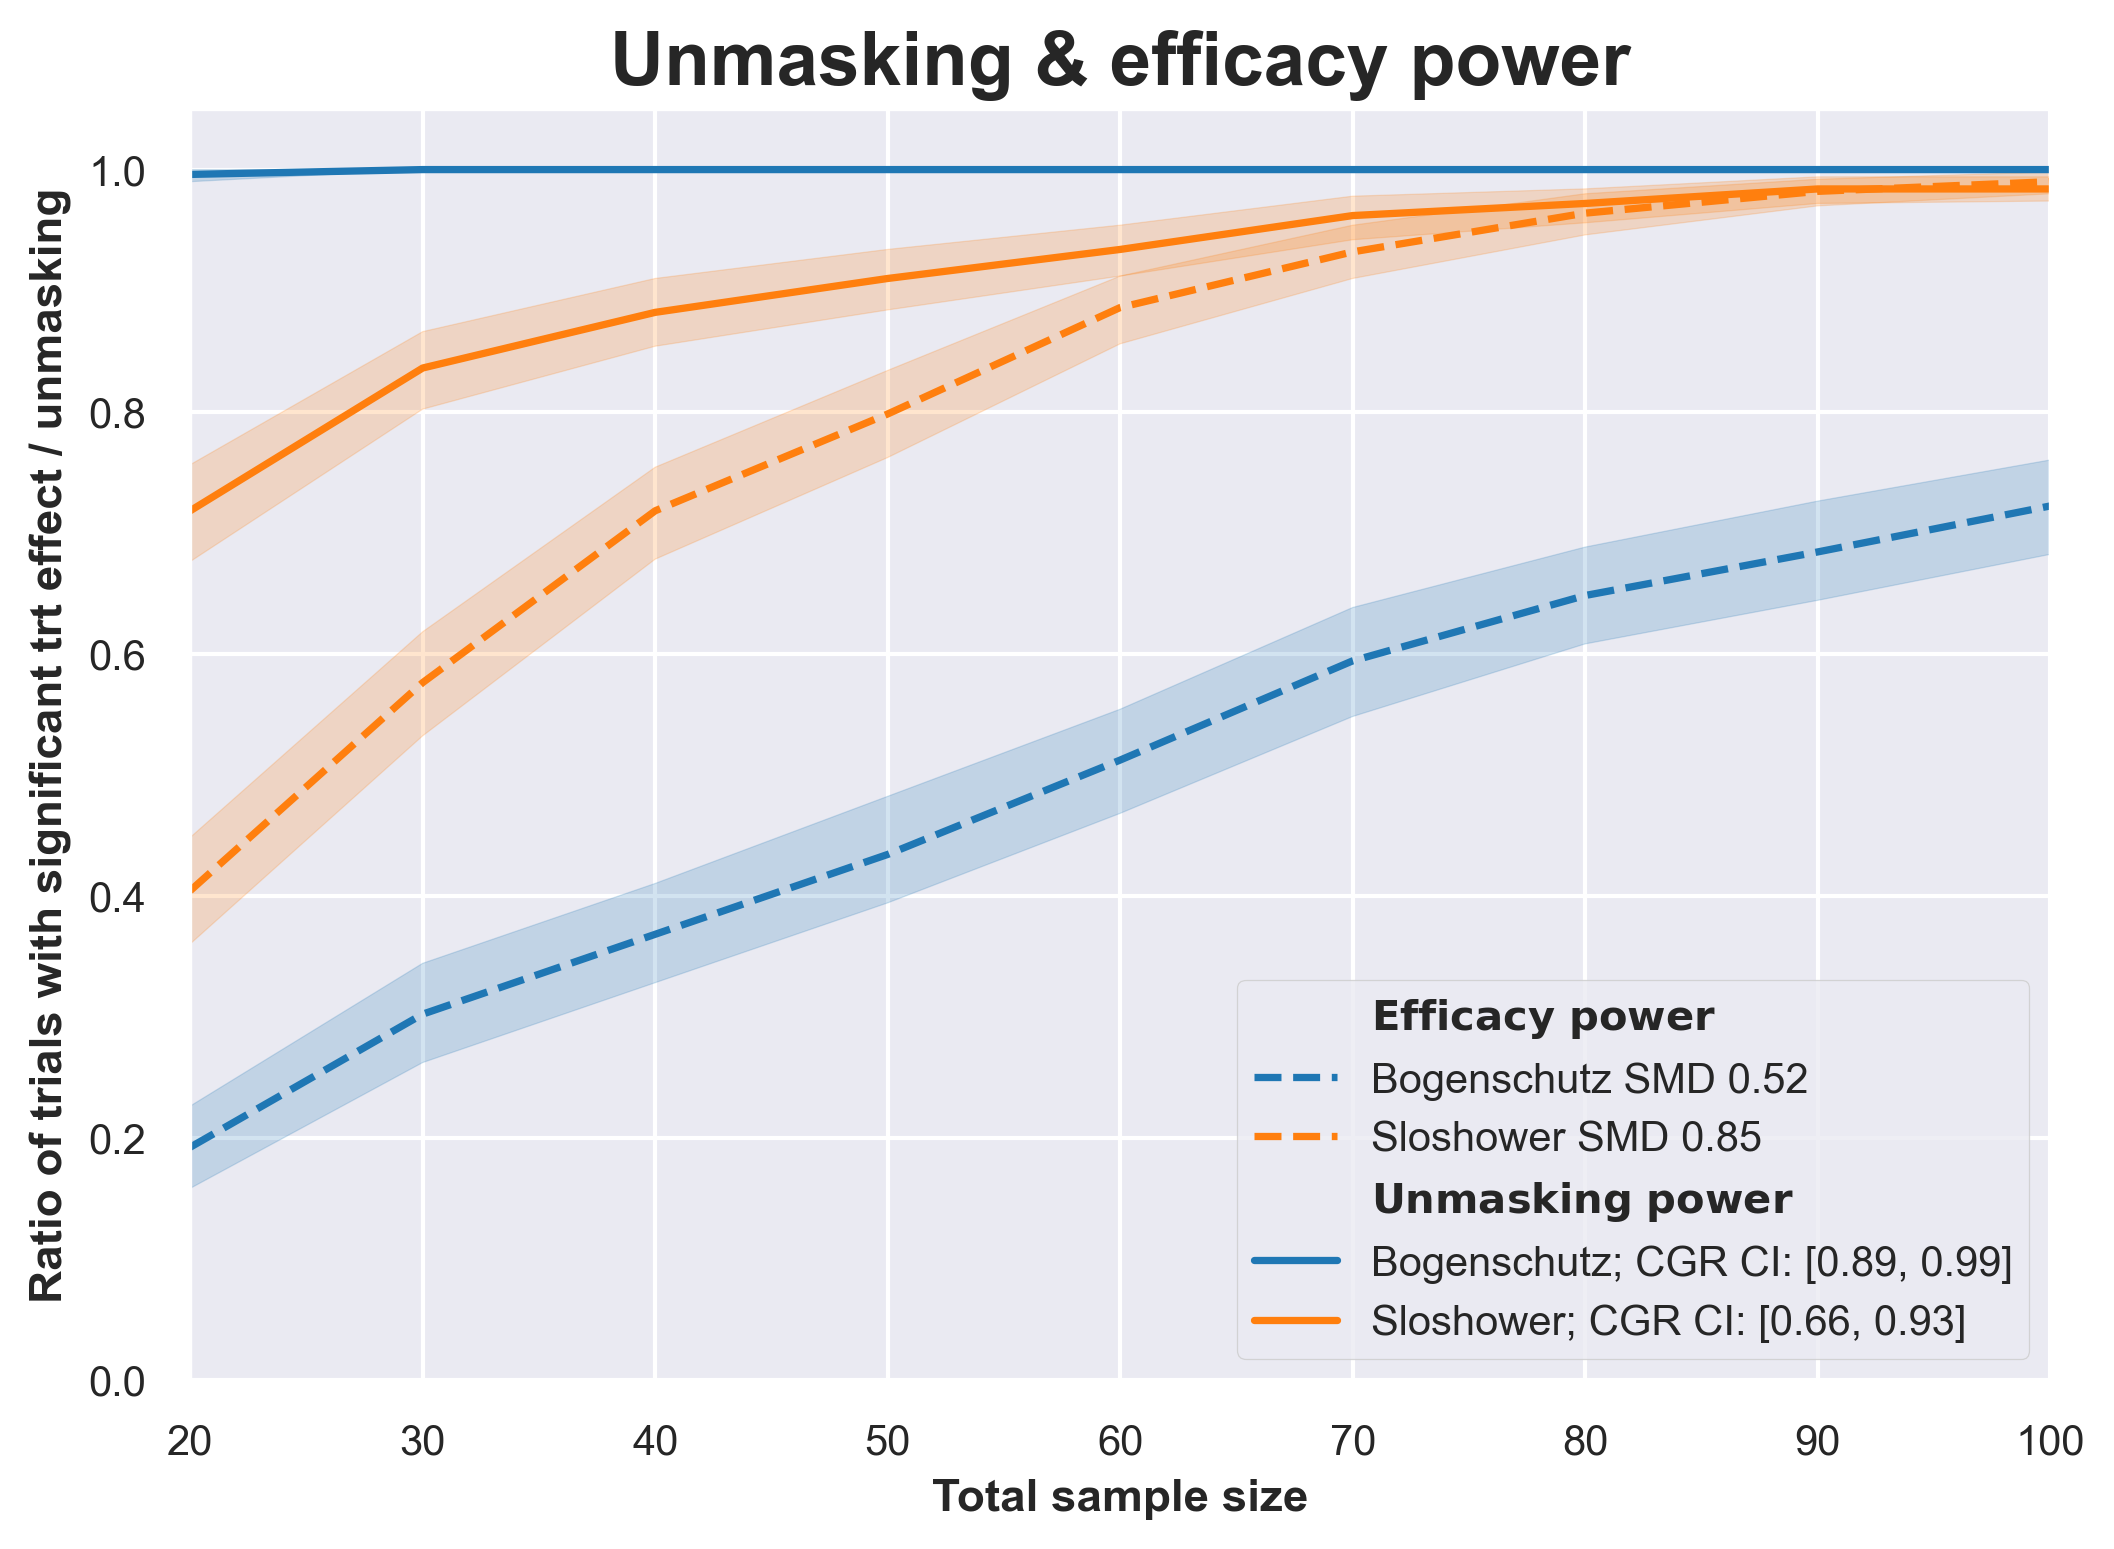

In [11]:
### Unmasking (CGR) & efficacy power plot 
fig, ax = plt.subplots()
sns.lineplot(
    data = df_outcomeCIs,
    x = 'sample', 
    y = 'value_sigdiff',
    hue = 'scenario',
    linestyle = '--',)

sns.lineplot(
    data = df_cgrCIs,
    x = 'sample', 
    y = 'cgr_sigdiff',
    #palette = ['red', 'black', 'brown'],
    hue = 'scenario',)

plt.title('Unmasking & efficacy power', fontweight='bold', fontsize=18)
ax.set_xlabel('Total sample size', fontweight='bold')
ax.set_ylabel('Ratio of trials with significant trt effect / unmasking', fontweight='bold')
ax.set_xlim([df_outcomeCIs['sample'].min(), 100]) # df_outcomeCIs['sample'].max()])
ax.set_ylim([0, 1.05])

### Hack to have subheadings within legend 
from matplotlib.patches import Patch
handles, labels = ax.get_legend_handles_labels()
blank_handle = Patch(facecolor='none', edgecolor='none', label='')  # invisible patch
subheading = r'$\bf{Efficacy\ power}$'
handles.insert(0, blank_handle)
labels.insert(0, subheading)
subheading = r'$\bf{Unmasking\ power}$'
handles.insert(3, blank_handle)
labels.insert(3, subheading)

plt.legend(
    handles = handles, 
    labels = labels,
    title = None, 
    title_fontproperties = {'weight': 'bold'},
    prop={'family': 'Arial'},
    loc='lower right')

save_fig(fig, 'power_mixed_studies_cgr')
plt.show()

# All real world trials to illutrate UP60

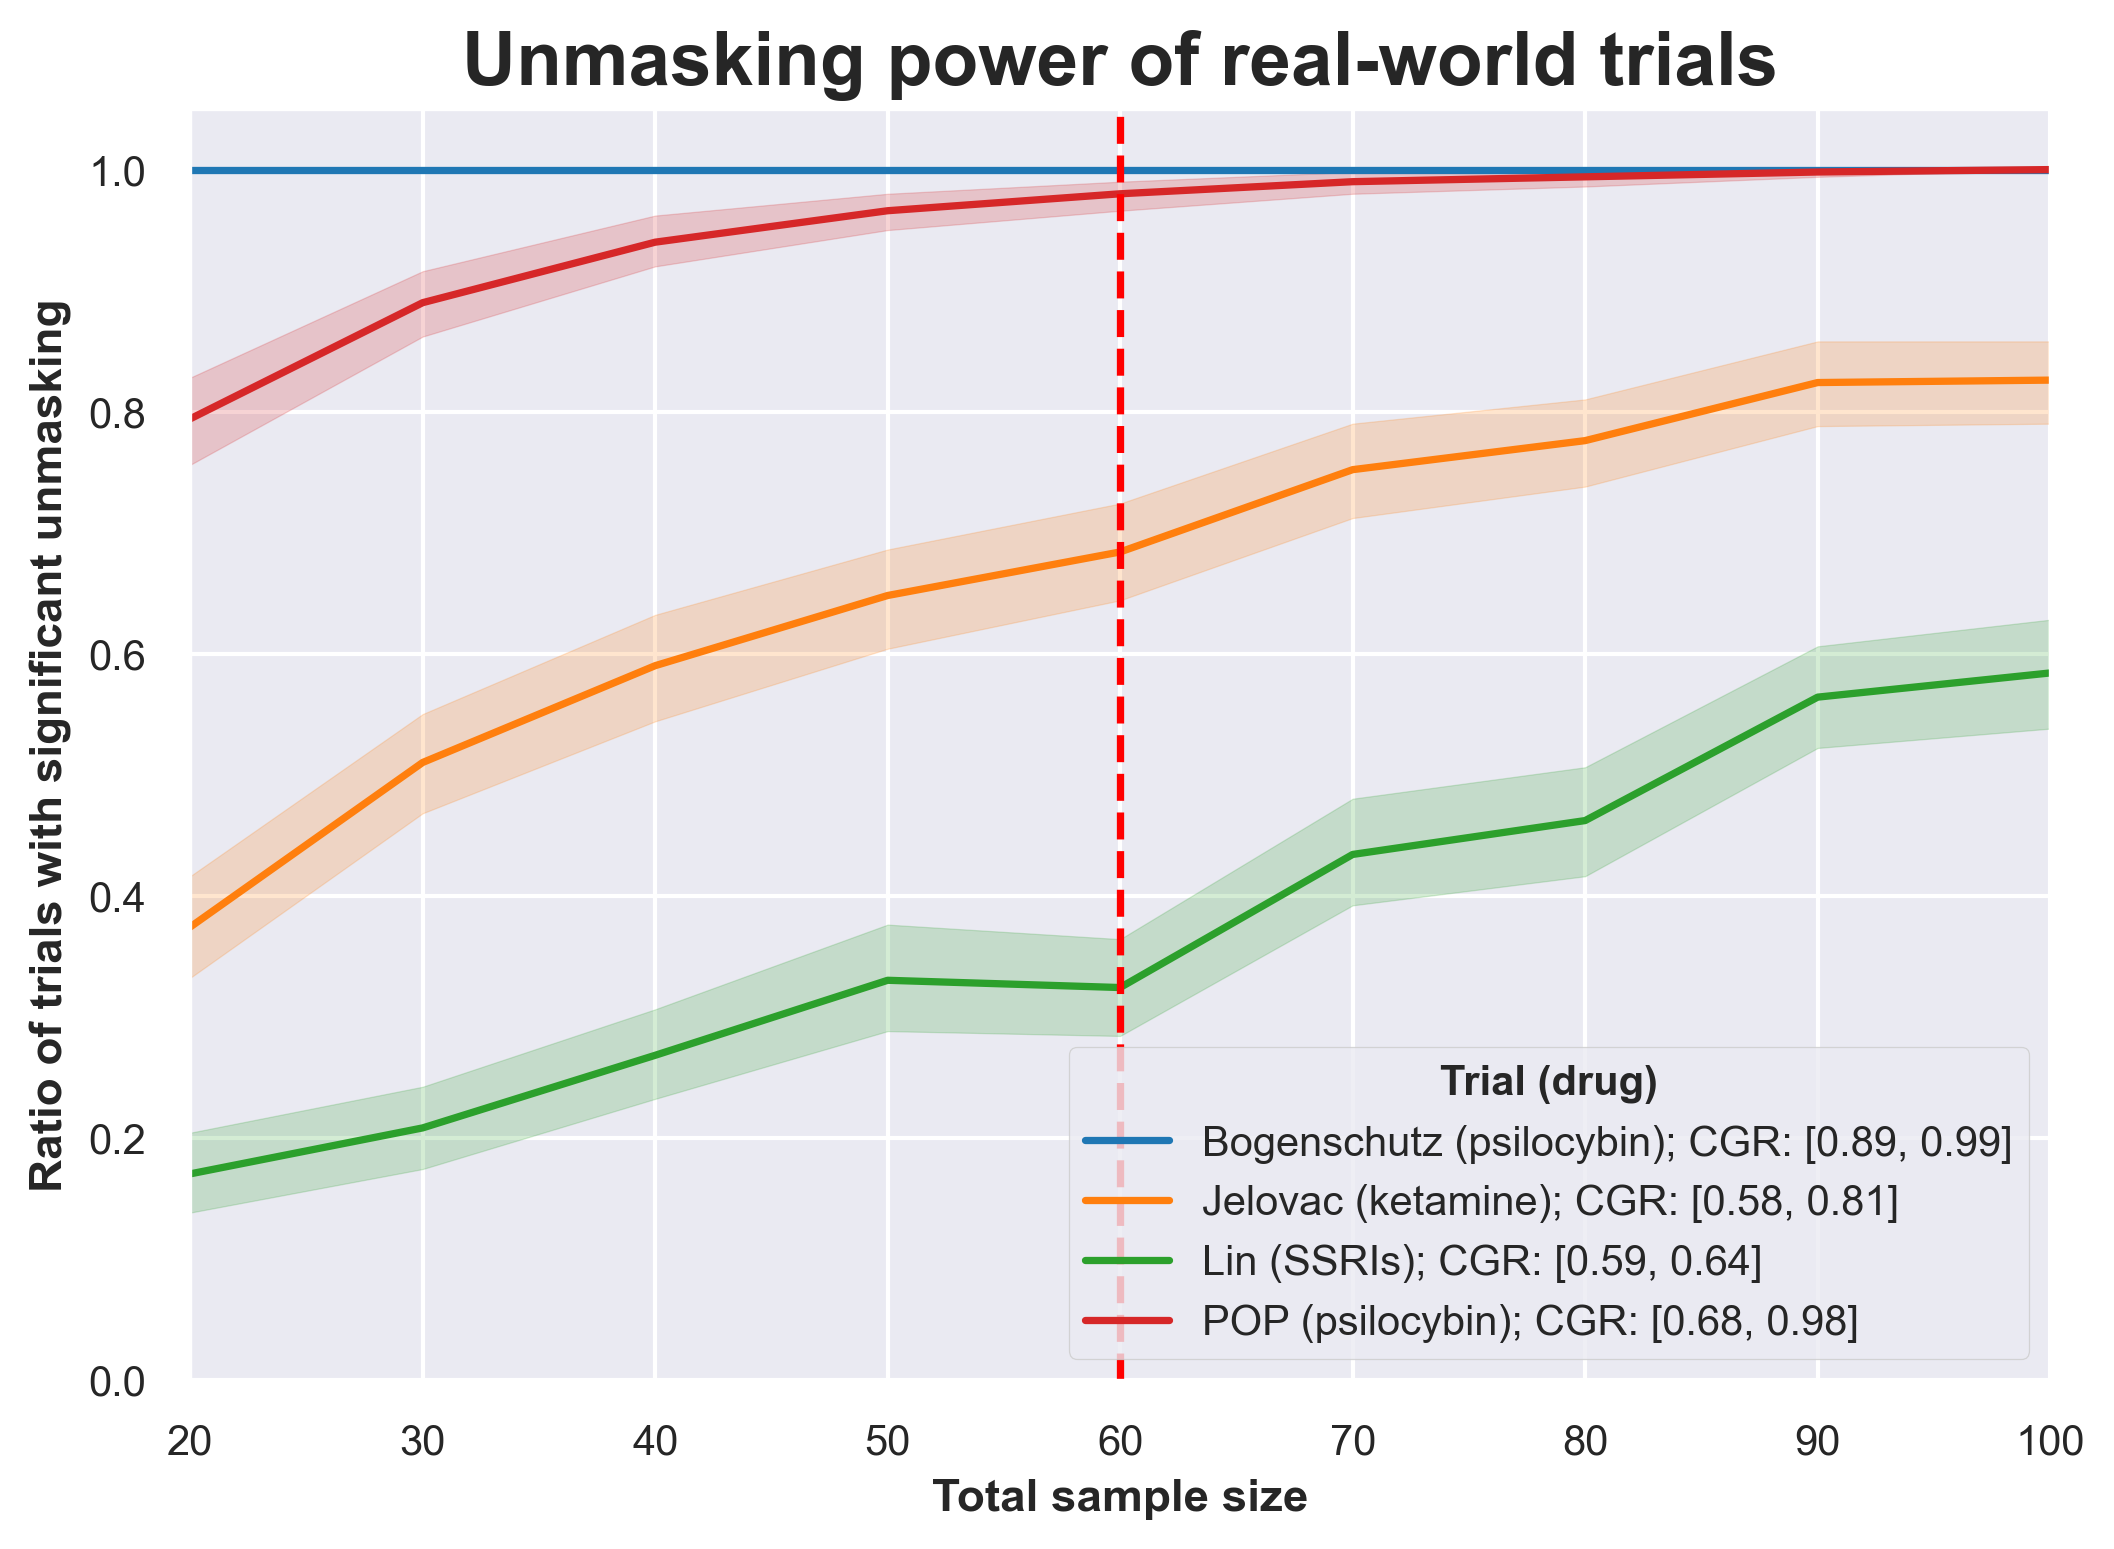

In [3]:
### All trials unmasking data to illusrtae UP50
n_trials = 500
sample = 100

scenarios = []
ciL, ciH = proportion_confint(89, 95) # Bogenschutz
scenarios.append((f'Bogenschutz (psilocybin); CGR: [{round(ciL,2)}, {round(ciH,2)}]', (ciL, ciH)))
ciL, ciH = proportion_confint(20, 24) # POP
scenarios.append((f'POP (psilocybin); CGR: [{round(ciL,2)}, {round(ciH,2)}]', (ciL, ciH)))
ciL, ciH = proportion_confint(43, 62)
scenarios.append((f'Jelovac (ketamine); CGR: [{round(ciL,2)}, {round(ciH,2)}]', (ciL, ciH)))
ciL, ciH = proportion_confint(724, 1177)
scenarios.append((f'Lin (SSRIs); CGR: [{round(ciL,2)}, {round(ciH,2)}]', (ciL, ciH)))

df_patientsData = []
for scenario in scenarios:
    scenario_name = scenario[0]
    ciL = round(scenario[1][0], 3)
    ciH = round(scenario[1][1], 3)
    
    for tID in np.arange(0, n_trials, 1):

        cgr = round(np.random.uniform(low=ciL, high=ciH), 3)
        scenario = f'{scenario_name}'
        params = {
            'type': 'binaryguess',
            'arm_params':{
                'C': {'cgr': cgr},
                'T': {'cgr': cgr},},}

        df = power.DataGeneration.get_df_patientsData(
            scenario = scenario, 
            n_trials = 1, 
            sample = sample, 
            params = [params])
        df['trial'] = tID
        df_patientsData.append(df)
df_patientsData = pd.concat(df_patientsData, ignore_index=True)

### Calculate CGR CIs
df_cgrCIs = power.Stats.get_df_cgrCIs_vector(
    df_patientsData, 
    samples = samples)
df_cgrCIs = power.Stats.add_sigdiff(df_cgrCIs)

### Unmasking (CGR) & efficacy power plot 
fig, ax = plt.subplots()
sns.lineplot(
    data = df_cgrCIs,
    x = 'sample', 
    y = 'cgr_sigdiff',
    hue = 'scenario',)
plt.title('Unmasking power of real-world trials', fontweight='bold', fontsize=18)
ax.axvline(x=60, color='red', linestyle='--')
ax.set_xlabel('Total sample size', fontweight='bold')
ax.set_ylabel('Ratio of trials with significant unmasking', fontweight='bold')
ax.set_xlim([df_cgrCIs['sample'].min(), 100]) # df_outcomeCIs['sample'].max()])
ax.set_ylim([0, 1.05])

plt.legend(
    title = 'Trial (drug)', 
    title_fontproperties = {'weight': 'bold'},
    prop={'family': 'Arial'},
    loc='lower right')

save_fig(fig, 'power_mixed_studies_cgr_extended')
plt.show()

# Real-world GMG unmasking vs. effiacy

In [ ]:
df_pop = power.Helpers.get_pop_data()
df_CIs = power.Stats.get_df_combinedCI(df_pop, col_value='gmg', col_ciL='gmg_ciL', col_ciH='gmg_ciH',)
df_CIs

In [ ]:
### Calc CI of the difference
ciL_C, ciH_C = df_CIs.loc[df_CIs.trt=='C', ['ciL', 'ciH']].values[0]
ciL_T, ciH_T = df_CIs.loc[df_CIs.trt=='T', ['ciL', 'ciH']].values[0]
ses = []    
for ciL, ciH in [(ciL_C, ciH_C),(ciL_T, ciH_T)]:
    ses.append((ciH - ciL) / (2 * 1.96))

mean_comb = ((ciH_T+ciL_T)/2 - (ciH_C+ciL_C)/2)/2
ses = np.array(ses)
se_comb = np.sqrt((ses**2).sum()) / np.sqrt(len(ses))

ciL_comb = float(round(mean_comb - 1.96*se_comb, 2))
ciH_comb = float(round(mean_comb + 1.96*se_comb, 2))
print(f'CI of the difference: {(ciL_comb, ciH_comb)}')

In [ ]:
df_diff = power.Stats.get_df_differenceCI(df_CIs, digits=3)
ciL_comb = float(round(df_diff.ciL.values[0], 1))
ciH_comb = float(round(df_diff.ciH.values[0], 1))
df_diff

In [ ]:
### Generate GMG data by sampling POP CI
# n_trials=300
sample=100

rows = []
for scenario in [f'POP; Δ guess CI: {(ciL_comb, ciH_comb)} mg']:
    for tID, pID in product(np.arange(0, n_trials, 1), np.arange(0, sample, 1)):
        
        trt = np.random.choice(['C', 'T'], size=1)
        trt = str(trt[0])

        ciL, ciH = df_CIs.loc[df_CIs.trt==trt, ['ciL', 'ciH']].values[0]

        row = {}
        row['scenario'] = scenario
        row['trial'] = tID
        row['trt'] = trt
        row['pID'] = pID
        row['gmg'] = round(np.random.uniform(low=ciL, high=ciH), 1)
        rows.append(row)
        
df_patientsData = pd.DataFrame(rows)

### Calculate GMG CIs
df_gmgCIs = power.Stats.get_df_diffCIs_vector(
    df_patientsData = df_patientsData, 
    samples = samples,
    col='gmg',) 
df_gmgCIs = power.Stats.add_sigdiff(df_gmgCIs)
df_gmgCIs.head(3)

In [ ]:
### Unmasking (CGR) & efficacy power plot 
fig, ax = plt.subplots()
sns.lineplot(
    data = df_outcomeCIs,
    x = 'sample', 
    y = 'value_sigdiff',
    hue = 'scenario',
    linestyle = '--',)

sns.lineplot(
    data = df_gmgCIs,
    x = 'sample', 
    y = 'gmg_sigdiff',
    palette = ['black'],
    hue = 'scenario',)

plt.title('Unmasking & efficacy power', fontweight='bold', fontsize=18)
ax.set_xlabel('Total sample size', fontweight='bold')
ax.set_ylabel('Ratio of trials with significant trt effect / unmasking', fontweight='bold')
ax.set_xlim([df_outcomeCIs['sample'].min(), 100]) # df_outcomeCIs['sample'].max()])
ax.set_ylim([0, 1.05])

### Hack to have subheadings within legend 
from matplotlib.patches import Patch
handles, labels = ax.get_legend_handles_labels()
blank_handle = Patch(facecolor='none', edgecolor='none', label='')  # invisible patch
subheading = r'$\bf{Efficacy\ power}$'
handles.insert(0, blank_handle)
labels.insert(0, subheading)
subheading = r'$\bf{Unmasking\ power}$'
handles.insert(4, blank_handle)
labels.insert(4, subheading)

plt.legend(
    handles = handles, 
    labels = labels,
    title = None, 
    title_fontproperties = {'weight': 'bold'},
    prop={'family': 'Arial'},
    loc='lower right')

save_fig(fig, 'power_mixed_studies_gmg')
plt.show()